In [1]:
import pandas as pd
import numpy as np
from grouprecommender import GroupRecommender

Using TensorFlow backend.


# Loading the Dataset

In [2]:
poorly_formatted_rows = [2120259, 2446317, 11141080, 11152098, 11152401, 11882086, 12902538, 12935043, 17589538]
df = pd.read_csv('lastfm_data/userid-timestamp-artid-artname-traid-traname.tsv', header=None, skiprows=poorly_formatted_rows, sep='\t')
df.columns = ['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
df.dropna(inplace=True)

# Group Recommendations

In [3]:
gr = GroupRecommender('utility_matrix.pickle',
                      dataset=df,
                      pickled_model_path='model.pickle',
                      embedding_model_path='embedding_model.yaml',
                      model_weights_path='embedding_model.h5',
                      embedding_space_path='embedding.npy',
                      dicts_path='song_dicts.pickle')

## Obtaining Group Recommendations

In [4]:
user_ids = np.random.choice(df['user_id'].unique(), 3, replace=False)
max_recommendations = 10
playlist = gr.full_recommendation(user_ids, max_recommendations, df, method='item2vec')

In [5]:
print("Recommended Songs for the Group:", user_ids)
for i, track in enumerate(playlist):
    print(str(i) + ')' + track[0] + ' - ' + track[1])

Recommended Songs for the Group: ['user_000546' 'user_000625' 'user_000109']
0)Röyksopp - Sparks
1)Justin Timberlake - Sexyback
2)Marilyn Manson - Heart-Shaped Glasses (When The Heart Guides The Hand)
3)Uriah Heep - Lady In Black
4)Sly & The Family Stone - If You Want Me To Stay
5)Vitalic - Repair Machines
6)The 69 Eyes - Velvet Touch
7)Akira Yamaoka - Theme Of Laura (Reprise)
8)Apocalyptica - Enter Sandman
9)The Chemical Brothers - Do It Again
10)Judas Priest - A Touch Of Evil


## Evaluating Recommendations

In [6]:
#TODO: implement evaluation method
track_ids = [track.track_id for track in playlist]
playlist_indexes = np.where(np.in1d(df['track_id'].dropna().unique(), track_ids))[0].tolist()
user_indexes = np.where(np.in1d(df['user_id'].dropna().unique(), user_ids))[0].tolist()
eval_score, similarity_score = gr.evaluate(user_indexes, playlist_indexes, method='custom')
print(eval_score, similarity_score)

3.13522209794 0.344874430773


In [7]:
playlist_indexes

[2412, 8502, 11897, 18477, 20849, 50993, 73991, 109068, 140789, 172434, 226320]

In [8]:
# for track in playlist_indexes:
#     for user in user_indexes:
#         print(gr.utility_matrix[track, user])
sel = df[df['user_id'] == 'user_000072']
sel[sel['artist_name'] == 'Capercaillie']
#user_ids

,user_id,timestamp,artist_id,artist_name,track_id,track_name


In [9]:
def test_groups(df, group_size, group_recommender, n_recommendations=5, n_groups=1000):
    n_users = len(df['user_id'].unique())
    groups = np.random.choice(range(n_users), (n_groups, group_size), replace=True)
    scores = []
    similarities = []
    for i, group in enumerate(groups):
        if i % 10 == 0:
            print(i)
        try:
            track_ids = group_recommender.item2vec_recommendation(group, n_recommendations)
            track_ids = np.where(np.in1d(df['track_id'].dropna().unique(), track_ids))[0].tolist()
            eval_score = group_recommender.evaluate(group, track_ids)
            if eval_score == np.nan:
                eval_score = 50.0
        except:
            eval_score = 50.0
        _, sim = group_recommender.avg_group_similarity(group)
        scores.append(eval_score)
        similarities.append(sim)
    corr = np.correlate(scores, similarities)[0]
    return scores, similarities, corr

In [10]:
from joblib import Parallel, delayed

In [11]:
results = Parallel(n_jobs=4, backend='threading')(
    delayed(test_groups)(df, i, gr, n_groups=100) for i in range(1, 6)
)

0
0
0
0


/Users/alex/Documents/itc/musicmagal/grouprecommender.py:255: RuntimeWarning: invalid value encountered in double_scalars
  rank = numerator / denominator


10


/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


20
10
30
40
50
20
10
60
70
80
30
90
10
0
40
20
50
60
30
20
70
80
40
10
90
50
30
60
40
20
70
80
50
90
30
60
40
70
80
50
90
60
70
80
90


In [12]:
scores = []
corrs = []
complete_scores = []
sims = []
complete_sims = []
for i in range(1, 11):
    print("Groups of size %d:" % i)
    sc, sims, corr = test_groups(df, i, gr)
    complete_scores.append(sc)
    complete_sims.append(sims)
    corrs.append(corr)
    scores.append(np.mean(sc))
    sims.append(np.mean(sims))
    print(np.mean(sc))
    print(np.mean(sims))
    print("-------------")

Groups of size 1:
0


/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/alex/Documents/itc/musicmagal/grouprecommender.py:255: RuntimeWarning: invalid value encountered in double_scalars
  rank = numerator / denominator


10
20
30
40
50
60
70
80
90
100
110
120
130


KeyboardInterrupt: 

In [ ]:
corrs

In [ ]:
np.array([1.515151515151515,
  0.0,
  31.111111111111107,
  56.666666666666664,
  22.916666666666664,
  26.190476190476186,
  0.0,
  0.0,
  9.523809523809522,
  33.33333333333333]).mean()

## Creating Group Playlist

In [13]:
import spotipy
import pprint
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

client_id = '5de79a00f1b9475098f277ce2a609120'
client_secret = '909633d1415345fe89882b6e398390df'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                          client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [14]:
spotify_track_ids = []
for track in playlist:
    search_str = track[0] + ' ' + track[1]
    result = sp.search(search_str, limit=1)
    spotify_track_ids.append(result['tracks']['items'][0]['id'])

In [15]:
playlist_name = 'Group recommendations for '
playlist_name += ', '.join(user_ids)

In [16]:
username = '11130460071'
scope='playlist-modify-public'
token = util.prompt_for_user_token(username, 
                                   client_id=client_id, 
                                   client_secret=client_secret, 
                                   redirect_uri='https://github.com/alexing10/musicmagal',
                                   scope=scope)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=5de79a00f1b9475098f277ce2a609120&response_type=code&redirect_uri=https%3A%2F%2Fgithub.com%2Falexing10%2Fmusicmagal&scope=playlist-modify-public in your browser


Enter the URL you were redirected to: https://github.com/alexing10/musicmagal?code=AQAFbdANUnu_3yJr2eid-n-ID_YtT60SSeQnRDDYksJZAuQf74Ej0wj1-ZvYCd9RqOwVc2QZMjBosce-9NDKwlNrria4pVP4Ni7PmAh0beEcVOOM7fqH1pouSfocgmekMkpqCXMoWzHHW3qfCYOXtXYFAZ1FFqhPlpWTnx6ed1H2XCEo0qM54d-VzSd9JuBBhyneDwKN5EbMvuW9dVBMXy3q4zBegvfAB1dOWUg7QWMr61eHIw




In [17]:
sp = spotipy.Spotify(auth=token)
playlist = sp.user_playlist_create(username, playlist_name)
sp.user_playlist_add_tracks(username, playlist['id'], spotify_track_ids)
print("boom!")

boom!


In [19]:
playlist_id = '0ChGv9bC33XK1zLtA78y9F'
sp.user_playlist_add_tracks(username, playlist_id, spotify_track_ids)

{'snapshot_id': 'oRoC3cCOO7mnauSmpMKZpVtSHgzRSSjGlAFVyyajNmNXYltq4fC0QA65082rDFtp'}

In [21]:
len(results)

5

In [35]:
x = results[0][1]

In [37]:
x = [n for n in x if ~np.isnan(n)]

In [38]:
np.mean(x)

1.0

In [45]:
mean_scores = []
mean_similarities = []
for result in results:
    scores = [x for x in result[0] if ~np.isnan(x)]
    similarities = [x for x in result[1] if ~np.isnan(x)]
    mean_scores.append(np.mean(scores))
    mean_similarities.append(np.mean(similarities))

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

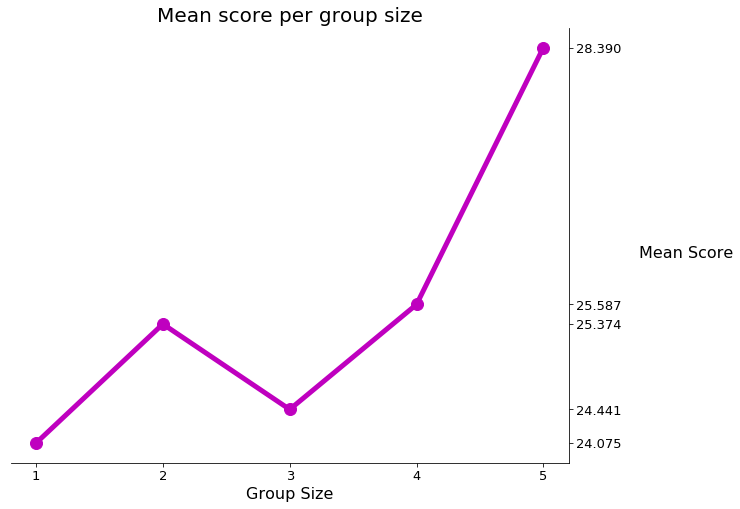

In [88]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(range(1, 6), mean_scores, 'o-', color='m', linewidth=5, markersize=12)
plt.xlabel('Group Size', fontsize=16)
ax.set_ylabel('Mean Score', fontsize=16, rotation=0, ha='right')
ax.yaxis.set_label_coords(1.21, 0.5)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xticks([1,2,3,4,5])
plt.yticks(mean_scores)
plt.tick_params(labelsize=13)
ax.set_title("Mean score per group size", fontdict={'fontsize': 20})



plt.show()

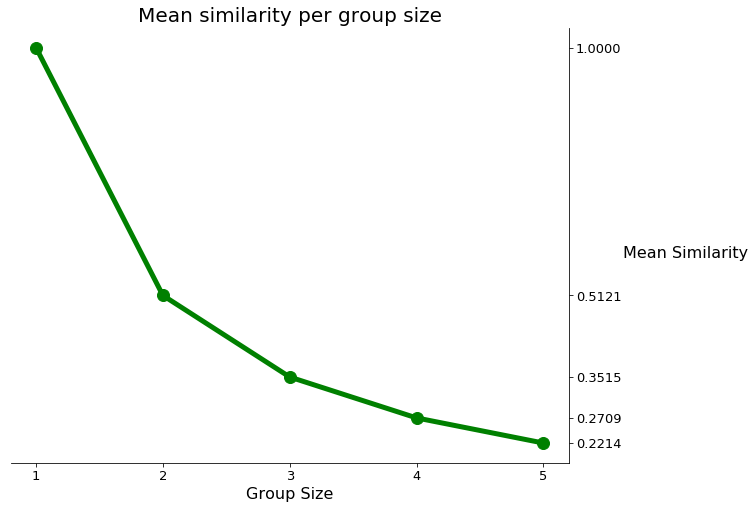

In [91]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(range(1, 6), mean_similarities, 'o-', color='g', linewidth=5, markersize=12)
plt.xlabel('Group Size', fontsize=16)
ax.set_ylabel('Mean Similarity', fontsize=16, rotation=0, ha='right')
ax.yaxis.set_label_coords(1.21, 0.5)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xticks([1,2,3,4,5])
plt.yticks(mean_similarities)
plt.tick_params(labelsize=13)
ax.set_title("Mean similarity per group size", fontdict={'fontsize': 20})
plt.show()
